<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# LightFM -  hybrid matrix factorisation on MovieLens (Python, CPU)

This notebook explains the concept of a hybrid matrix factorisation based model for recommendation, it also outlines the steps to construct a pure matrix factorisation and a hybrid models using the [LightFM](https://github.com/lyst/lightfm) package. It also demonstrates how to extract both user and item affinity from a fitted hybrid model.

## 1. Hybrid matrix factorisation model

### 1.1 Background

In general, most recommendation models can be divided into two categories:
- Content based model,
- Collaborative filtering model.

The content-based model recommends based on similarity of the items and/or users using their description/metadata/profile. On the other hand, collaborative filtering model (discussion is limited to matrix factorisation approach in this notebook) computes the latent factors of the users and items. It works based on the assumption that if a group of people expressed similar opinions on an item, these peole would tend to have similar opinions on other items. For further background and detailed explanation between these two approaches, the reader can refer to machine learning literatures [3, 4].

The choice between the two models is largely based on the data availability. For example, the collaborative filtering model is usually adopted and effective when sufficient ratings/feedbacks have been recorded for a group of users and items.

However, if there is a lack of ratings, content based model can be used provided that the metadata of the users and items are available. This is also the common approach to address the cold-start issues, where there are insufficient historical collaborative interactions available to model new users and/or items.

<!-- In addition, most collaborative filtering models only consume explicit ratings e.g. movie 

**NOTE** add stuff about implicit and explicit ratings -->

### 1.2 Hybrid matrix factorisation algorithm

In view of the above problems, there have been a number of proposals to address the cold-start issues by combining both content-based and collaborative filtering approaches. The hybrid matrix factorisation model is among one of the solutions proposed [1].  

In general, most hybrid approaches proposed different ways of assessing and/or combining the feature data in conjunction with the collaborative information.

### 1.3 LightFM package 

LightFM is a Python implementation of a hybrid recommendation algorithms for both implicit and explicit feedbacks [1].

It is a hybrid content-collaborative model which represents users and items as linear combinations of their content features’ latent factors. The model learns **embeddings or latent representations of the users and items in such a way that it encodes user preferences over items**. These representations produce scores for every item for a given user; items scored highly are more likely to be interesting to the user.

The user and item embeddings are estimated for every feature, and these features are then added together to be the final representations for users and items. 

For example, for user i, the model retrieves the i-th row of the feature matrix to find the features with non-zero weights. The embeddings for these features will then be added together to become the user representation e.g. if user 10 has weight 1 in the 5th column of the user feature matrix, and weight 3 in the 20th column, the user 10’s representation is the sum of embedding for the 5th and the 20th features multiplying their corresponding weights. The representation for each items is computed in the same approach. 

#### 1.3.1 Modelling approach

Let $U$ be the set of users and $I$ be the set of items, and each user can be described by a set of user features $f_{u} \subset F^{U}$ whilst each items can be described by item features $f_{i} \subset F^{I}$. Both $F^{U}$ and $F^{I}$ are all the features which fully describe all users and items. 

The LightFM model operates based binary feedbacks, the ratings will be normalised into two groups. The user-item interaction pairs $(u,i) \in U\times I$ are the union of positive (favourable reviews) $S^+$ and negative interactions (negative reviews) $S^-$ for explicit ratings. For implicit feedbacks, these can be the observed and not observed interactions respectively.

For each user and item feature, their embeddings are $e_{f}^{U}$ and $e_{f}^{I}$ respectively. Furthermore, each feature is also has a scalar bias term ($b_U^f$ for user and $b_I^f$ for item features). The embedding (latent representation) of user $u$ and item $i$ are the sum of its respective features’ latent vectors:

$$ 
q_{u} = \sum_{j \in f_{u}} e_{j}^{U}
$$

$$
p_{i} = \sum_{j \in f_{i}} e_{j}^{I}
$$

Similarly the biases for user $u$ and item $i$ are the sum of its respective bias vectors. These variables capture the variation in behaviour across users and items:

$$
b_{u} = \sum_{j \in f_{u}} b_{j}^{U}
$$

$$
b_{i} = \sum_{j \in f_{i}} b_{j}^{I}
$$

In LightFM, the representation for each user/item is a linear weighted sum of its feature vectors.

The prediction for user $u$ and item $i$ can be modelled as sigmoid of the dot product of user and item vectors, adjusted by its feature biases as follows:

$$
\hat{r}_{ui} = \sigma (q_{u} \cdot p_{i} + b_{u} + b_{i})
$$

As the LightFM is constructed to predict binary outcomes e.g. $S^+$ and $S^-$, the function $\sigma()$ is based on the [sigmoid function](https://mathworld.wolfram.com/SigmoidFunction.html). 

The LightFM algorithm estimates interaction latent vectors and bias for features. For model fitting, the cost function of the model consists of maximising the likelihood of data conditional on the parameters described above using stochastic gradient descent. The likelihood can be expressed as follows:

$$
L = \prod_{(u,i) \in S+}\hat{r}_{ui} \times \prod_{(u,i) \in S-}1 - \hat{r}_{ui}
$$

Note that if the feature latent vectors are not available, the algorithm will behaves like a [logistic matrix factorisation model](http://stanford.edu/~rezab/nips2014workshop/submits/logmat.pdf).

## 2. Movie recommender with LightFM using only explicit feedbacks

### 2.1 Import libraries

In [1]:
import sys
sys.path.append("../../")
import os

import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation

# Import LightFM's evaluation metrics
from lightfm.evaluation import precision_at_k as lightfm_prec_at_k
from lightfm.evaluation import recall_at_k as lightfm_recall_at_k

# Import repo's evaluation metrics
from reco_utils.evaluation.python_evaluation import (
    precision_at_k, recall_at_k)

from reco_utils.common.timer import Timer
from reco_utils.dataset import movielens
from reco_utils.recommender.lightfm.lightfm_utils import (
    track_model_metrics, prepare_test_df, prepare_all_predictions,
    compare_metric, similar_users, similar_items)

print("System version: {}".format(sys.version))
print("LightFM version: {}".format(lightfm.__version__))

/Users/samarthhadawale/opt/miniconda3/envs/reco_base/lib/python3.6/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


System version: 3.6.10 |Anaconda, Inc.| (default, May  7 2020, 23:06:31) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
LightFM version: 1.15


### 2.2 Defining variables

In [2]:
# Select MovieLens data size
MOVIELENS_DATA_SIZE = '100k'

# default number of recommendations
K = 10
# percentage of data used for testing
TEST_PERCENTAGE = 0.25
# model learning rate
LEARNING_RATE = 0.25
# no of latent factors
NO_COMPONENTS = 20
# no of epochs to fit model
NO_EPOCHS = 20
# no of threads to fit model
NO_THREADS = 32
# regularisation for both user and item features
ITEM_ALPHA=1e-6
USER_ALPHA=1e-6

# seed for pseudonumber generations
SEEDNO = 42

In [3]:
import pandas as pd
#read CSV1
CSV1 = pd.read_csv('snack_first.csv', delimiter=",")#Skip rows if required, skiprows=2)
#read CSV2
CSV2 = pd.read_csv('itemInfo.csv', delimiter=",")#Skip rows if required, skiprows=2)
#Combine CSV
CombinedCSV = pd.merge(CSV1, CSV2, left_on=['itemID'], right_on=['itemID'])
CombinedCSV.drop('Unnamed: 0', axis = 1, inplace = True)
#Save the CSV
#CombinedCSV.sample(10)
CombinedCSV.to_csv('CombinedCSV.csv', sep=',', index=False, encoding='utf-8')

In [4]:
df = pd.read_csv('CombinedCSV.csv')
df

,userID,itemID,rating,itemName,category
0,1882,6,3,Egg & cheese wrap,EggFood
1,1966,6,1,Egg & cheese wrap,EggFood
2,1569,6,3,Egg & cheese wrap,EggFood
3,396,6,2,Egg & cheese wrap,EggFood
4,591,6,1,Egg & cheese wrap,EggFood
...,...,...,...,...,...
9995,1636,11,3,Hot Tea,Drinks
9996,1117,11,4,Hot Tea,Drinks
9997,1773,11,1,Hot Tea,Drinks
9998,635,11,4,Hot Tea,Drinks


In [5]:
df.drop('itemName', axis = 1, inplace = True)
df

,userID,itemID,rating,category
0,1882,6,3,EggFood
1,1966,6,1,EggFood
2,1569,6,3,EggFood
3,396,6,2,EggFood
4,591,6,1,EggFood
...,...,...,...,...
9995,1636,11,3,Drinks
9996,1117,11,4,Drinks
9997,1773,11,1,Drinks
9998,635,11,4,Drinks


In [6]:
df.to_csv('newData.csv', index = False)

In [8]:
import pandas as pd
#read CSV1
CSV3 = pd.read_csv('CombinedCSV.csv', delimiter=",")#Skip rows if required, skiprows=2)
#read CSV2
CSV4 = pd.read_csv('userData.csv', delimiter=",")#Skip rows if required, skiprows=2)
#Combine CSV
CombinedCSV1 = pd.merge(CSV3, CSV4, left_on=['userID'], right_on=['userID'])
#Save the CSV
#df.drop('col3', axis = 1, inplace = True)
#CombinedCSV1.sample(10)
CombinedCSV1.to_csv('CombinedCSV1.csv', sep=',', index=False, encoding='utf-8')

In [9]:
df = pd.read_csv('CombinedCSV1.csv')
df

,userID,itemID,rating,itemName,category,userName,occupation
0,1882,6,3,Egg & cheese wrap,EggFood,Albert Stout,professor
1,1882,22,4,12 Piece Donut Sticks,Veg,Albert Stout,professor
2,1882,9,4,Hot Chocolate,Drinks,Albert Stout,professor
3,1882,30,3,Filet-O-Fish,SeaFood,Albert Stout,professor
4,1882,28,4,Baked Apple Pie,Drinks,Albert Stout,professor
...,...,...,...,...,...,...,...
9995,759,35,3,Fish & Chips,SeaFood,Carla Baker,sportsperson
9996,759,1,3,Veggie Egg White Burger,EggFood,Carla Baker,sportsperson
9997,474,29,3,Chicken McNuggets,Non Veg,Teresa Simpson,doctor
9998,1218,11,4,Hot Tea,Drinks,Brenda Moore,dancer


In [10]:
df.drop('itemName', axis = 1, inplace = True)
df.drop('userName', axis = 1, inplace = True)
df

,userID,itemID,rating,category,occupation
0,1882,6,3,EggFood,professor
1,1882,22,4,Veg,professor
2,1882,9,4,Drinks,professor
3,1882,30,3,SeaFood,professor
4,1882,28,4,Drinks,professor
...,...,...,...,...,...
9995,759,35,3,SeaFood,sportsperson
9996,759,1,3,EggFood,sportsperson
9997,474,29,3,Non Veg,doctor
9998,1218,11,4,Drinks,dancer


In [11]:
df.to_csv('combo.csv', index = False)

### 2.2 Retrieve data

In [12]:
data = pd.read_csv("newData.csv")

# quick look at the data
data.sample(5)

,userID,itemID,rating,category
795,1129,16,2,Drinks
9854,745,11,2,Drinks
5792,1754,20,1,Veg
447,119,39,4,Non Veg
8768,1806,31,4,Non Veg


### 2.3 Prepare data

Before fitting the LightFM model, we need to create an instance of `Dataset` which holds the interaction matrix.

In [13]:
dataset = Dataset()

The `fit` method creates the user/item id mappings.

In [14]:
dataset.fit(users=data['userID'], 
            items=data['itemID'])

# quick check to determine the number of unique users and items in the data
num_users, num_topics = dataset.interactions_shape()
print(f'Num users: {num_users}, num_topics: {num_topics}.')

Num users: 1986, num_topics: 49.


Next is to build the interaction matrix. The `build_interactions` method returns 2 COO sparse matrices, namely the `interactions` and `weights` matrices.

In [15]:
(interactions, weights) = dataset.build_interactions(data.iloc[:, 0:3].values)

LightLM works slightly differently compared to other packages as it expects the train and test sets to have same dimension. Therefore the conventional train test split will not work.

The package has included the `cross_validation.random_train_test_split` method to split the interaction data and splits it into two disjoint training and test sets. 

However, note that **it does not validate the interactions in the test set to guarantee all items and users have historical interactions in the training set**. Therefore this may result into a partial cold-start problem in the test set.

In [16]:
train_interactions, test_interactions = cross_validation.random_train_test_split(
    interactions, test_percentage=TEST_PERCENTAGE,
    random_state=np.random.RandomState(SEEDNO))

Double check the size of both the train and test sets.

In [17]:
print(f"Shape of train interactions: {train_interactions.shape}")
print(f"Shape of test interactions: {test_interactions.shape}")

Shape of train interactions: (1986, 49)
Shape of test interactions: (1986, 49)


### 2.4 Fit the LightFM model

In this notebook, the LightFM model will be using the weighted Approximate-Rank Pairwise (WARP) as the loss. Further explanation on the topic can be found [here](https://making.lyst.com/lightfm/docs/examples/warp_loss.html#learning-to-rank-using-the-warp-loss).


In general, it maximises the rank of positive examples by repeatedly sampling negative examples until a rank violation has been located. This approach is recommended when only positive interactions are present.

In [18]:
model1 = LightFM(loss='warp', no_components=NO_COMPONENTS, 
                 learning_rate=LEARNING_RATE,                 
                 random_state=np.random.RandomState(SEEDNO))

The LightFM model can be fitted with the following code:

In [19]:
model1.fit(interactions=train_interactions,
          epochs=NO_EPOCHS);

### 2.5 Prepare model evaluation data

Before we can evaluate the fitted model and to get the data into a format which is compatible with the existing evaluation methods within this repo, the data needs to be massaged slightly.

First the train/test indices need to be extracted from the `lightfm.cross_validation` method as follows:

In [20]:
uids, iids, interaction_data = cross_validation._shuffle(
    interactions.row, interactions.col, interactions.data, 
    random_state=np.random.RandomState(SEEDNO))

cutoff = int((1.0 - TEST_PERCENTAGE) * len(uids))
test_idx = slice(cutoff, None)

Then the the mapping between internal and external representation of the user and item are extracted as follows:

In [21]:
uid_map, ufeature_map, iid_map, ifeature_map = dataset.mapping()

Once the train/test indices and mapping are ready, the test dataframe can be constructed as follows:

In [22]:
with Timer() as test_time:
    test_df = prepare_test_df(test_idx, uids, iids, uid_map, iid_map, weights)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict test data.")  
time_reco1 = test_time.interval

Took 0.2 seconds for prepare and predict test data.


And samples of the test dataframe:

In [23]:
test_df.sample(5)

,userID,itemID,rating
921,685,25,3.0
737,1203,40,1.0
1454,422,37,1.0
2185,936,48,1.0
2006,1982,20,4.0


In addition, the predictions of all unseen user-item pairs (e.g. removing those seen in the training data) can be prepared as follows:

In [24]:
with Timer() as test_time:
    all_predictions = prepare_all_predictions(data, uid_map, iid_map, 
                                              interactions=train_interactions,
                                              model=model1, 
                                              num_threads=NO_THREADS)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict all data.")
time_reco2 = test_time.interval

Took 20.7 seconds for prepare and predict all data.


Samples of the `all_predictions` dataframe:

In [25]:
all_predictions.head(5)

,userID,itemID,prediction
0,1882,39,-5.792186
1,1882,25,-5.876668
2,1882,16,-5.335219
3,1882,27,-5.027680
4,1882,19,-4.729632


Note that the **raw prediction values from the LightFM model are for ranking purposes only**, they should not be used directly. The magnitude and sign of these values do not have any specific interpretation.

### 2.6 Model evaluation

Once the evaluation data are ready, they can be passed into to the repo's evaluation methods as follows. The performance of the model will be tracked using both Precision@K and Recall@K.

In addition, the results have also being compared with those computed from LightFM's own evaluation methods to ensure accuracy.

In [28]:
with Timer() as test_time:
    eval_precision = precision_at_k(rating_true=test_df, 
                                rating_pred=all_predictions, k=K)
    eval_recall = recall_at_k(test_df, all_predictions, k=K)
time_reco3 = test_time.interval


    
print(
    "------ Using Repo's evaluation methods ------",
    f"Precision@K:\t{eval_precision:.6f}",
    f"Recall@K:\t{eval_recall:.6f}",
    "\n------ Using LightFM evaluation methods ------",
    f"Precision@K:\t{eval_precision:.6f}",
    f"Recall@K:\t{eval_recall:.6f}", 
    sep='\n')



------ Using Repo's evaluation methods ------
Precision@K:	0.035137
Recall@K:	0.204193

------ Using LightFM evaluation methods ------
Precision@K:	0.035137
Recall@K:	0.204193


## 3. Movie recommender with LightFM using explicit feedbacks and additional item and user features

As the LightFM was designed to incorporates both user and item metadata, the model can be extended to include additional features such as movie genres and user occupations.

### 3.1 Extract and prepare movie genres

In this notebook, the movie's genres will be used as the item metadata. As the genres have already been loaded during the initial data import, it can be processed directly as follows:

In [29]:
# split the genre based on the separator
snack_category = [x.split('|') for x in data['category']]

In [30]:
# retrieve the all the unique genres in the data
all_snack_category = sorted(list(set(itertools.chain.from_iterable(snack_category))))
# quick look at the all the genres within the data
all_snack_category

['Bakery', 'Drinks', 'EggFood', 'Non Veg', 'SeaFood', 'Veg']

### 3.2 Retrieve and prepare movie genres

Further user features can be included as part of the model fitting process. In this notebook, **only the occupation of each user will be included** but the feature list can be extended easily.


#### 3.2.1 Retrieve and merge data

The user features can be retrieved directly from the grouplens website and merged with the existing data as follows:

In [31]:
import pandas as pd
#read CSV1
csvnew = pd.read_csv('combo.csv', delimiter=",")
csvnew.sample(5)

,userID,itemID,rating,category,occupation
6671,1429,9,2,Drinks,sportsperson
8688,314,8,3,Drinks,doctor
2323,1073,20,1,Veg,scientist
9005,332,37,2,Veg,professor
9256,347,4,1,Non Veg,musician


#### 3.2.2 Extract and prepare user occupations

In [32]:
# retrieve all the unique occupations in the data
all_occupations = sorted(list(set(csvnew['occupation'])))
#all_itemNames = sorted(list(set(new_data['itemName'])))

In [33]:
all_occupations

['architecturer',
 'dancer',
 'doctor',
 'educator',
 'engineer',
 'musician',
 'professor',
 'scientist',
 'sportsperson',
 'student']

### 3.3 Prepare data and features

Similar to the previous model, the data is required to be converted into a `Dataset` instance and then create a user/item id mapping with the `fit` method.

In [34]:
dataset2 = Dataset()
dataset2.fit(data['userID'], 
            data['itemID'], 
            item_features=all_snack_category,
            user_features=all_occupations)

The movie genres are then converted into a item feature matrix using the `build_item_features` method as follows:

In [35]:
item_features = dataset2.build_item_features(
    (x, y) for x,y in zip(data.itemID, snack_category))

The user occupations are then converted into an user feature matrix using the `build_user_features` method as follows:

In [36]:
user_features = dataset2.build_user_features(
    (x, [y]) for x,y in zip(csvnew.userID, csvnew['occupation']))

Once the item and user features matrices have been completed, the next steps are similar as before, which is to build the interaction matrix and split the interactions into train and test sets as follows:

In [37]:
(interactions2, weights2) = dataset2.build_interactions(data.iloc[:, 0:3].values)

train_interactions2, test_interactions2 = cross_validation.random_train_test_split(
    interactions2, test_percentage=TEST_PERCENTAGE,
    random_state=np.random.RandomState(SEEDNO))

### 3.3 Fit the LightFM model with additional user and item features

The parameters of the second model will be similar to the first model to facilitates comparison.

The model performance at each epoch is also tracked by the same metrics as before.

In [38]:
model2 = LightFM(loss='warp', no_components=NO_COMPONENTS, 
                 learning_rate=LEARNING_RATE, 
                 item_alpha=ITEM_ALPHA,
                 user_alpha=USER_ALPHA,
                 random_state=np.random.RandomState(SEEDNO))

The LightFM model can then be fitted:

In [39]:
model2.fit(interactions=train_interactions2,
           user_features=user_features,
           item_features=item_features,
           epochs=NO_EPOCHS);

### 3.4 Prepare model evaluation data

Similar to the previous model, the evaluation data needs to be prepared in order to get them into a format consumable with this repo's evaluation methods.

Firstly the train/test indices and id mappings are extracted using the new interations matrix as follows:

In [40]:
uids, iids, interaction_data = cross_validation._shuffle(
    interactions2.row, interactions2.col, interactions2.data, 
    random_state=np.random.RandomState(SEEDNO))

uid_map, ufeature_map, iid_map, ifeature_map = dataset2.mapping()

The test dataframe is then constructed as follows:

In [41]:
with Timer() as test_time:
    test_df2 = prepare_test_df(test_idx, uids, iids, uid_map, iid_map, weights2)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict test data.")  

Took 0.2 seconds for prepare and predict test data.


The predictions of all unseen user-item pairs can be prepared as follows:

In [42]:
with Timer() as test_time:
    all_predictions2 = prepare_all_predictions(data, uid_map, iid_map, 
                                              interactions=train_interactions2,
                                               user_features=user_features,
                                               item_features=item_features,
                                               model=model2,
                                               num_threads=NO_THREADS)

print(f"Took {test_time.interval:.1f} seconds for prepare and predict all data.")

Took 10.3 seconds for prepare and predict all data.


### 3.5 Model evaluation and comparison

The predictive performance of the new model can be computed and compared with the previous model (which used only the explicit rating) as follows:

In [43]:
eval_precision2 = precision_at_k(rating_true=test_df2, 
                                rating_pred=all_predictions2, k=K)
eval_recall2 = recall_at_k(test_df2, all_predictions2, k=K)

print(
    "------ Using only explicit ratings ------",
    f"Precision@K:\t{eval_precision:.6f}",
    f"Recall@K:\t{eval_recall:.6f}",
    "\n------ Using both implicit and explicit ratings ------",
    f"Precision@K:\t{eval_precision2:.6f}",
    f"Recall@K:\t{eval_recall2:.6f}",
    sep='\n')

------ Using only explicit ratings ------
Precision@K:	0.035137
Recall@K:	0.204193

------ Using both implicit and explicit ratings ------
Precision@K:	0.034786
Recall@K:	0.197470


The new model which used both implicit and explicit data performed consistently better than the previous model which used only the explicit data, thus highlighting the benefits of including such additional features to the model.

### 3.6 Evaluation metrics comparison

Note that the evaluation approaches here are solely for demonstration purposes only.

If the reader were using the LightFM package and/or its models, the LightFM's built-in evaluation methods are much more efficient and are the recommended approach for production usage as they are designed and optimised to work with the package.

As a comparison, the times recorded to compute Precision@K and Recall@K for model1 are shown as follows:

In [45]:
print(
    "------ Using Repo's evaluation methods ------",
    f"Time [sec]:\t{(time_reco1+time_reco2+time_reco3):.1f}",
    "\n------ Using Reco3 evaluation methods ------",
    f"Time [sec]:\t{time_reco3:.1f}",
    sep='\n')

------ Using Repo's evaluation methods ------
Time [sec]:	21.1

------ Using Reco3 evaluation methods ------
Time [sec]:	0.2


## 4. Evaluate model fitting process

In addition to the inclusion of both implicit and explicit data, the model fitting process can also be monitored in order to determine whether the model is being trained properly. 

This notebook also includes a `track_model_metrics` method which plots the model's metrics e.g. Precision@K and Recall@K as model fitting progresses.

For the first model (using only explicit data), the model fitting progress is shown as follows:

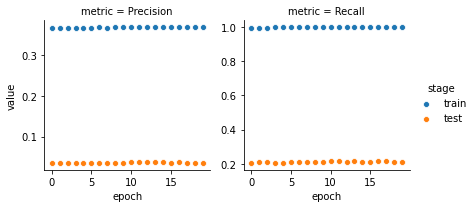

In [46]:
output1, _ = track_model_metrics(model=model1, train_interactions=train_interactions, 
                              test_interactions=test_interactions, k=K,
                              no_epochs=NO_EPOCHS, no_threads=NO_THREADS)

The second model (with both implicit and explicit data) fitting progress:

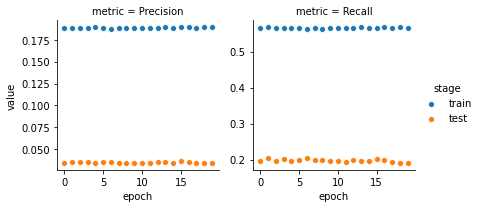

In [47]:
output2, _ = track_model_metrics(model=model2, train_interactions=train_interactions2, 
                              test_interactions=test_interactions2, k=K,
                              no_epochs=NO_EPOCHS, no_threads=NO_THREADS, 
                              item_features=item_features,
                              user_features=user_features)

These show slightly different behaviour with the two approaches, the reader can then tune the hyperparameters to improve the model fitting process.


### 4.1 Performance comparison

In addition, the model's performance metrics (based on the test dataset) can be plotted together to facilitate easier comparison as follows:

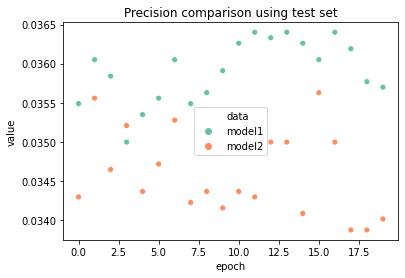

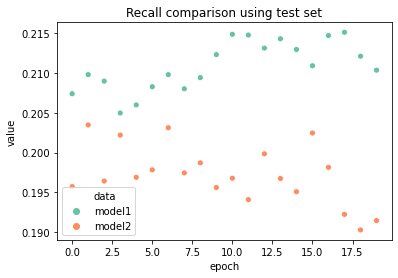

In [48]:
for i in ['Precision', 'Recall']:
    sns.set_palette("Set2")
    plt.figure()
    sns.scatterplot(x="epoch", y="value", hue='data',
                data=compare_metric(df_list = [output1, output2], metric=i)
               ).set_title(f'{i} comparison using test set');

Referring to the figures above, it is rather obvious that the number of epochs is too low as the model's performances have not stabilised. Reader can decide on the number of epochs and other hyperparameters to adjust suit the application.

As stated previously, it is interesting to see model2 (using both implicit and explicit data) performed consistently better than model1 (using only explicit ratings). 

## 5. Similar users and items

As the LightFM package operates based on latent embeddings, these can be retrieved once the model has been fitted to assess user-user and/or item-item affinity.

### 5.1 User affinity

The user-user affinity can be retrieved with the `get_user_representations` method from the fitted model as follows:

In [49]:
_, user_embeddings = model2.get_user_representations(features=user_features)
user_embeddings

array([[-0.02974548,  0.13362125,  0.01469166, ..., -0.12555502,
        -0.15871574, -0.14754163],
       [-0.01355443,  0.1286718 , -0.01955781, ...,  0.1695354 ,
         0.07169569,  0.01830241],
       [ 0.02001765, -0.20841312,  0.20336077, ...,  0.07847667,
        -0.00645639, -0.11383063],
       ...,
       [-0.22921169,  0.14460745,  0.27031246, ..., -0.0493646 ,
        -0.19700459, -0.24988446],
       [-0.05310027, -0.1744692 ,  0.4407758 , ...,  0.17230359,
         0.1004099 , -0.08691695],
       [ 0.09033205,  0.1312466 , -0.19402936, ..., -0.12504409,
        -0.08688013, -0.1673107 ]], dtype=float32)

In order to retrieve the top N similar users, we can use the `similar_users` from `reco_utils`. For example, if we want to choose top 10 users most similar to the user 1:

In [50]:
similar_users(user_id=1, user_features=user_features, 
            model=model2)

,userID,score
0,219,0.950485
1,1275,0.924122
2,396,0.908587
3,478,0.901460
4,1857,0.891283
5,480,0.885426
6,921,0.844836
7,216,0.839836
8,638,0.828526
9,127,0.816388


### 5.2 Item affinity

Similar to the user affinity, the item-item affinity can be retrieved with the `get_item_representations` method using the fitted model.

In [52]:
_, item_embeddings = model2.get_item_representations(features=item_features)
item_embeddings

array([[-1.2779155 , -2.17041   ,  0.21881385, -2.3424869 , -2.730267  ,
        -2.0225549 ,  1.0715013 , -2.987382  ,  0.11873934,  1.5918509 ,
        -2.2983644 ,  2.5346923 , -0.9301003 , -3.78875   , -1.5787847 ,
         1.3261718 , -0.78089285, -1.4162772 , -2.494765  , -1.3398958 ],
       [ 0.91899884,  0.3040301 , -1.4868786 , -0.09228779, -0.2143421 ,
         0.27990606,  0.16683619,  0.5601561 ,  1.0558313 ,  1.9122062 ,
         0.51160896, -0.50601095, -1.8541884 ,  0.19238348,  0.00711856,
        -0.6739319 ,  1.1515119 , -0.05499447,  0.11451154,  0.65424806],
       [ 0.67299086, -0.9784672 ,  1.8631854 , -0.4055122 ,  0.3979986 ,
        -0.12226643,  0.22642021,  1.2208852 , -0.28067392, -0.48121753,
        -0.2979444 , -1.5554268 ,  0.5499207 , -0.7731006 , -0.5367456 ,
         0.02486317,  0.75247276,  0.9713467 ,  0.49239358, -0.17741258],
       [ 0.24880514,  0.64683956, -0.8711915 ,  0.835449  , -0.11902016,
        -0.4066274 ,  0.47902715, -0.5886082 , -

The function to retrieve the top N similar items is similar to similar_users() above. For example, if we want to choose top 10 items most similar to the item 10:

In [53]:
similar_items(item_id=10, item_features=item_features, 
            model=model2)

,itemID,score
0,29,1.000000
1,15,1.000000
2,34,0.999999
3,46,0.999999
4,11,0.999999
5,26,0.999999
6,32,0.999999
7,42,0.999999
8,2,0.999999
9,17,0.999998


In [324]:
all_predictions[all_predictions['userID'] == 2]

,userID,itemID,prediction
33968,2,6,-3.823840
33969,2,22,-3.544358
33970,2,39,-3.813453
33971,2,25,-9.517488
33972,2,27,-7.130971
33973,2,19,-5.052196
33974,2,17,-5.207697
33975,2,47,-4.552753
33976,2,9,-4.980853
33977,2,3,-3.580595


## 6. Conclusion

In this notebook, the background of hybrid matrix factorisation model has been explained together with a detailed example of LightFM's implementation. 

The process of incorporating additional user and item metadata has also been demonstrated with performance comparison. Furthermore, the calculation of both user and item affinity scores have also been demonstrated and extracted from the fitted model.

This notebook remains a fairly simple treatment on the subject and hopefully could serve as a good foundation for the reader.

## References

- [[1](https://arxiv.org/abs/1507.08439)]. Maciej Kula - Metadata Embeddings for User and Item Cold-start Recommendations, 2015. arXiv:1507.08439
- [[2](https://making.lyst.com/lightfm/docs/home.html)]. LightFM documentation,
- [3]. Charu C. Aggarwal - Recommender Systems: The Textbook, Springer, April 2016. ISBN 978-3-319-29659-3
- [4]. Deepak K. Agarwal, Bee-Chung Chen - Statistical Methods for Recommender Systems, 2016. ISBN: 9781107036079 
